In [1]:
import os
import subprocess
import umap
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from statsmodels.formula.api import mixedlm
from pygam import LinearGAM, s, f

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-23 03:24:47.860450: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from statsmodels.regression.mixed_linear_model import MixedLM

In [3]:
audio_folder = '/Users/caihanzhe/Desktop/Comoros_Data_1'
output_folder = '/Users/caihanzhe/Desktop/Python/Comoros/BirdNet_MoreData/Outputs'
os.makedirs(output_folder, exist_ok=True)
embeddings_script = "/Users/caihanzhe/Desktop/Python/Birdnet_Test/BirdNET-Analyzer/embeddings.py"
venv_activation = "/Users/caihanzhe/Desktop/Python/Birdnet_Test/BirdNET-Analyzer/venv-birdnet/bin/activate"

In [4]:
#Forest cover of sites
forest_cover_df = pd.read_csv('/Users/caihanzhe/Desktop/mean_ndvi_values.csv')
# forest_cover_df = forest_cover_df.drop(columns=['NDVI'])

In [7]:
forest_cover_df

,plot_id,NDVI,Forest_Cover,alt,alt_level
0,S1,0.277405,Medium,966,Medium
1,S2,0.309501,Medium,1002,Medium
2,S3,0.297727,Medium,1016,Medium
3,S4,NaN,Low,1076,Medium
4,S5,0.280381,Medium,796,Low
5,S6,0.159493,Low,1010,Medium
6,S7,0.220075,Medium,1192,Medium
7,S8,0.305322,Medium,1279,High
8,S9,0.309687,Medium,1471,High
9,S10,0.273092,Medium,1332,High


In [6]:
def assign_alt_level(row_):
    if 600 <= row_['alt'] < 900:
        return 'Low'
    elif 900 <= row_['alt'] < 1200:
        return 'Medium'
    else:
        return 'High'

forest_cover_df['alt_level'] = forest_cover_df.apply(assign_alt_level, axis=1)

In [8]:
# Read BirdNet detection CSV file
detection_df = pd.read_csv('/Users/caihanzhe/Desktop/Python/Comoros/BirdNet_detection/all_data.csv')
detection_df['date'] = pd.to_datetime(detection_df['date'])

In [ ]:
for subdir, dirs, files in os.walk(audio_folder):
    for file in files:
        if file.endswith('.WAV'):
            audio_path = os.path.join(subdir, file)
            relative_path = os.path.relpath(subdir, audio_folder)
            output_subdir = os.path.join(output_folder, relative_path)
            os.makedirs(output_subdir, exist_ok=True)
            output_path = os.path.join(output_subdir, file.replace('.WAV', '.csv'))

            command = f"source {venv_activation} && python3 {embeddings_script} --i \"{audio_path}\" --o \"{output_path}\" --threads 4 --batchsize 16"
            subprocess.run(command, shell=True)

In [8]:
embeddings = []

for subdir_1 in os.listdir(output_folder):
    subdir_1_path = os.path.join(output_folder, subdir_1)
    if os.path.isdir(subdir_1_path):
        for file_1 in os.listdir(subdir_1_path):
            if file_1.endswith('.csv'):
                try:
                    path = os.path.join(subdir_1_path, file_1)
                    df = pd.read_csv(path, header=None)
                    subdir_1_path = Path(subdir_1_path)
                    site_code, site_name = subdir_1_path.name.split(' - ')
                    date = datetime.datetime.strptime(file_1, '%Y%m%d_%H%M%S.csv')
                    time = date.strftime('%H:%M')
                    df['site_code'] = site_code
                    df['site_name'] = site_name
                    df['date'] = date
                    df['time'] = time
                    df['path'] = path
                    df['start_time'] = df[0].apply(lambda x: float(x.split('\t')[0]))
                    df['end_time'] = df[0].apply(lambda x: float(x.split('\t')[1]))
                    embeddings.append(df)
                except Exception as e:
                    print(f"Failed to read {file_1}: {e}")

In [9]:
full_df = pd.concat(embeddings)

In [10]:
full_df

,0,1,2,3,4,5,6,7,8,9,...,1021,1022,1023,site_code,site_name,date,time,path,start_time,end_time
0,0\t3.0\t0.0,0.244216,0.212980,0.532420,0.506945,0.174773,0.141772,0.659547,0.212724,0.115545,...,0.549599,0.000000,0.681342,S18,Ouzini Hacobambi forest 2,2023-08-09 00:00:01,00:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,0.0,3.0
1,3.0\t6.0\t0.014952471,0.146149,0.100536,0.380987,0.559546,0.433513,0.326163,0.806330,0.116692,0.148672,...,0.597401,0.000000,1.169614,S18,Ouzini Hacobambi forest 2,2023-08-09 00:00:01,00:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,3.0,6.0
2,6.0\t9.0\t0.0,0.177056,0.202209,0.236383,0.287241,0.311885,0.162211,0.474637,0.264233,0.302880,...,0.573778,0.000000,1.145363,S18,Ouzini Hacobambi forest 2,2023-08-09 00:00:01,00:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,6.0,9.0
3,9.0\t12.0\t0.0,0.427186,0.097491,0.241876,0.474096,0.187673,0.847422,0.263049,0.504163,0.077837,...,0.248519,0.000000,1.534915,S18,Ouzini Hacobambi forest 2,2023-08-09 00:00:01,00:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,9.0,12.0
4,12.0\t15.0\t0.020033548,0.000000,0.208147,0.208893,0.322215,0.561710,0.957973,0.630024,0.327668,0.121870,...,0.444532,0.000000,1.610130,S18,Ouzini Hacobambi forest 2,2023-08-09 00:00:01,00:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,12.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,285.0\t288.0\t0.0,0.000000,0.293283,0.340934,0.031145,0.104854,0.464975,0.000000,0.120725,0.447897,...,0.751451,0.000000,2.068227,S19,Ouzini Pinzani foret,2023-07-16 21:00:01,21:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,285.0,288.0
96,288.0\t291.0\t0.0,0.000000,0.372179,0.279753,0.113964,0.040009,0.074455,0.000000,0.065560,0.484931,...,0.772974,0.000000,1.859302,S19,Ouzini Pinzani foret,2023-07-16 21:00:01,21:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,288.0,291.0
97,291.0\t294.0\t0.0,0.000000,0.378403,1.043289,0.000064,0.000000,0.039642,0.000000,0.013816,0.453076,...,1.787196,0.040892,2.712847,S19,Ouzini Pinzani foret,2023-07-16 21:00:01,21:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,291.0,294.0
98,294.0\t297.0\t0.0,0.000000,0.305311,0.557503,0.000000,0.000000,0.920742,0.000000,0.170002,0.129968,...,1.697727,0.000000,3.111702,S19,Ouzini Pinzani foret,2023-07-16 21:00:01,21:00,/Users/caihanzhe/Desktop/Python/Comoros/BirdNe...,294.0,297.0


In [6]:
# full_df.to_csv('/Users/caihanzhe/Desktop/Python/Comoros/BirdNet_MoreData/full_df.csv', index=False)

In [14]:
# Process full_df with detection of Birdnet and get the species richness
full_df_detected = pd.merge(full_df, detection_df[['start_time', 'end_time', 'Common Name', 'site_code', 'date']],
                   on=['start_time', 'end_time', 'site_code', 'date'], how='left')
species_df = full_df_detected[['site_code', 'Common Name']]
species_df = species_df.dropna(subset=['Common Name'])
species_richness = species_df.groupby('site_code')['Common Name'].nunique().reset_index()
species_richness.columns = ['site_code', 'species_richness']
print(species_richness)

In [11]:
# Get species richness by running the cluster algorithm
AP_results = pd.read_csv('/Users/caihanzhe/Desktop/Python/Comoros/BirdNet_MoreData/AP_results.csv')
AP_results = AP_results.drop(columns=['silhouette_score'])
AP_results.columns = ['site', 'species_richness']

In [12]:
AP_results

,site,species_richness
0,S18,826
1,S10,25
2,S29,604
3,S40,194
4,S36,559
5,S27,1021
6,S39,746
7,S15,301
8,S34,375
9,S8,254


In [13]:
#  Average Embeddings over 1 min
full_df['site_date'] = full_df['site_code'] + ' ' + full_df['date'].astype(str)
time_intervals = [(0, 60.0), (60.0, 120.0), (120.0, 180.0), (180.0, 240.0), (240.0, 300.0)]
def average_embeddings_1(df2):
    averages = []
    for start, end in time_intervals:
        interval_df = df2[(df2['start_time'] >= start) & (df2['end_time'] <= end)]
        if not interval_df.empty:
            avg_embedding = interval_df.iloc[:, 1:1024].mean()
            avg_embedding['site_date'] = df2['site_date'].iloc[0]
            averages.append(avg_embedding)
    return pd.DataFrame(averages)

grouped_ = full_df.groupby('site_date')
minute_averages = grouped_.apply(average_embeddings_1).reset_index(drop=True)

/var/folders/n3/rz_cmx5j30j2f1f32by1w3m80000gn/T/ipykernel_24377/2792033430.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  minute_averages = grouped_.apply(average_embeddings_1).reset_index(drop=True)


In [14]:
minute_averages

,1,2,3,4,5,6,7,8,9,10,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,site_date
0,0.737747,0.321804,0.199757,1.148175,0.617247,0.068538,0.164663,0.055251,0.115827,0.222751,...,0.259817,0.152996,0.433664,0.178073,0.310281,0.276615,1.334090,0.207503,0.336296,S1 2023-07-03 18:00:01
1,0.744160,0.398255,0.285658,1.220065,0.601682,0.100306,0.221565,0.084049,0.098012,0.230972,...,0.209673,0.162265,0.245538,0.122513,0.348146,0.248252,1.423939,0.169516,0.333624,S1 2023-07-03 18:00:01
2,0.743534,0.502413,0.236235,1.068902,0.321240,0.203735,0.291291,0.127624,0.022790,0.223548,...,0.161396,0.172793,0.162127,0.124793,0.164673,0.142702,0.568918,0.178173,0.623377,S1 2023-07-03 18:00:01
3,0.737687,0.266936,0.217434,0.935921,0.423511,0.207963,0.083609,0.080737,0.112797,0.228495,...,0.186596,0.060484,0.245278,0.117628,0.323617,0.186693,1.048283,0.169118,0.450670,S1 2023-07-03 18:00:01
4,0.698215,0.371960,0.216048,0.950592,0.604693,0.193568,0.096358,0.105427,0.097938,0.293194,...,0.158477,0.212966,0.374977,0.131509,0.365173,0.360464,1.069801,0.224375,0.329722,S1 2023-07-03 18:00:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,0.172305,0.201551,0.099482,0.655344,0.346617,0.045257,0.007022,0.329275,0.088447,0.730226,...,0.196400,0.220121,0.175496,0.219912,0.138566,0.441243,0.442020,0.079811,0.748935,S9 2023-09-07 05:45:01
5725,0.076707,0.192777,0.151829,0.706951,0.353370,0.070909,0.041273,0.188589,0.120235,0.522149,...,0.198017,0.122003,0.240498,0.129336,0.180004,0.137569,0.419180,0.044131,0.561369,S9 2023-09-07 05:45:01
5726,0.130333,0.177402,0.102814,0.640438,0.381724,0.173471,0.059907,0.271900,0.161195,0.488801,...,0.186838,0.154374,0.307349,0.155200,0.230142,0.113964,0.279409,0.067917,0.356211,S9 2023-09-07 05:45:01
5727,0.124633,0.281102,0.076158,0.417014,0.482330,0.079683,0.022426,0.291933,0.070392,0.786848,...,0.161759,0.115010,0.246658,0.095714,0.176049,0.128517,0.525049,0.017738,0.474816,S9 2023-09-07 05:45:01


In [72]:
minute_averages.to_csv('/Users/caihanzhe/Desktop/Python/Comoros/BirdNet_MoreData/df_1min_aver.csv', index=False)

In [31]:
# minute_averages = minute_averages.drop(columns=['PC4'])

In [15]:
# Average Embeddings over 1 min
minute_averages[['site', '1']] = minute_averages['site_date'].str.split(' ', expand=True, n=1)
minute_averages[['2', 'time']] = minute_averages['1'].str.split(' ', expand=True, n=1)
minute_averages.drop(columns=['1', '2'], inplace=True)

In [16]:
minute_averages['time'] = minute_averages['time'].str.slice(0, 5)

In [17]:
minute_averages = pd.merge(minute_averages, forest_cover_df, left_on='site', right_on='plot_id', how='left')

In [18]:
minute_averages = minute_averages.drop(columns=['plot_id'])

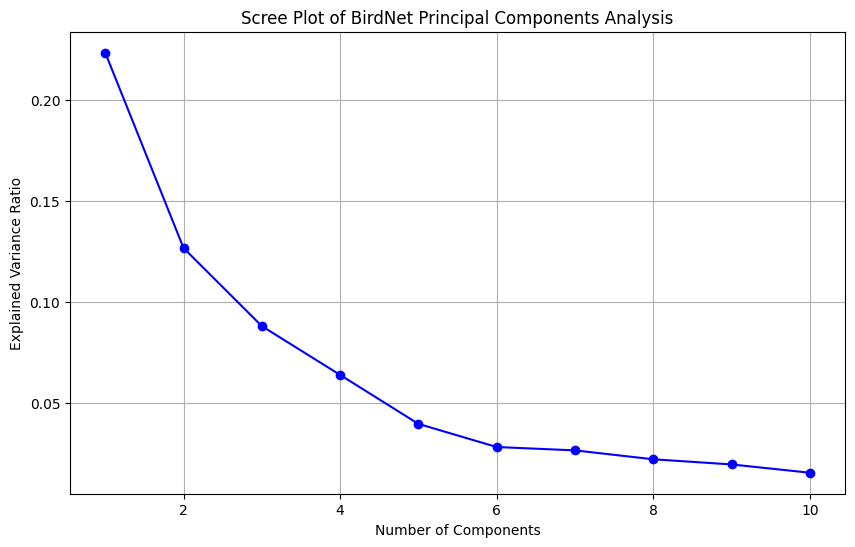

In [19]:
# PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(minute_averages.iloc[:, :1023])
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-', color='b')
plt.title('Scree Plot of BirdNet Principal Components Analysis')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [20]:
# PCA
for i in range(4):
    minute_averages[f'PC{i+1}'] = principal_components[:, i]

In [21]:
# Average Embeddings over 1 min
aver_select_1 = minute_averages.iloc[:, 0:1023].values

In [22]:
# Average Embeddings over 1 min
scaler = StandardScaler()
aver_scaled_1 = scaler.fit_transform(aver_select_1)

In [23]:
# Average Embeddings over 1 min
reducer = umap.UMAP(random_state=42)
aver_2d_1 = reducer.fit_transform(aver_scaled_1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [24]:
# Average Embeddings over 1 min
minute_averages['UMAP1'] = aver_2d_1[:, 0]
minute_averages['UMAP2'] = aver_2d_1[:, 1]

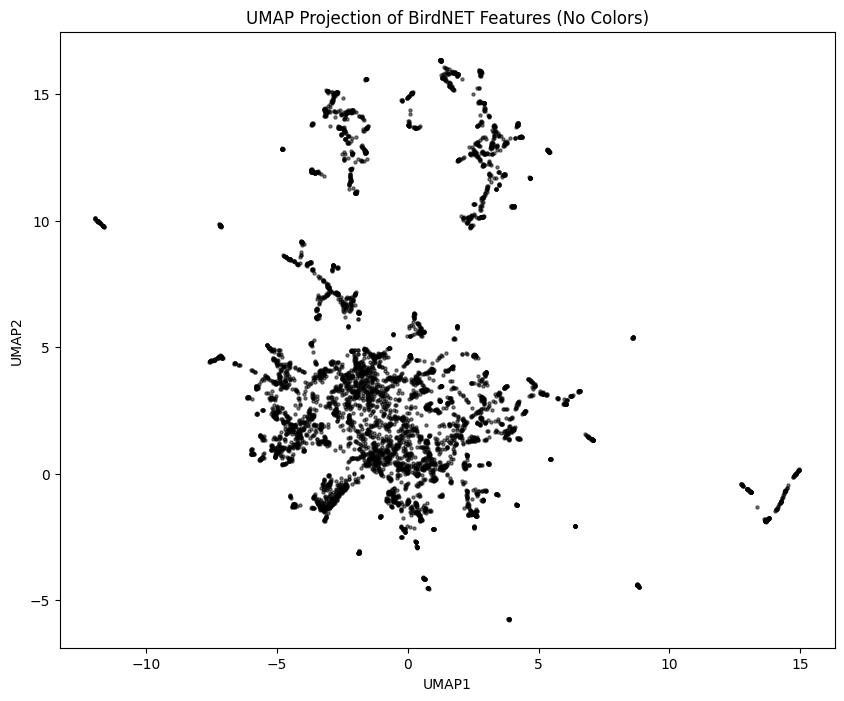

In [25]:
# Average Embeddings over 1 min No colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(minute_averages['UMAP1'], minute_averages['UMAP2'], color='black', alpha=0.5, s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of BirdNET Features (No Colors)')
plt.show()

In [26]:
def generate_distinct_colors(num_colors):
    hsv_colors = [(i / num_colors, 1.0, 1.0) for i in range(num_colors)]
    rgb_colors = [mcolors.hsv_to_rgb(hsv) for hsv in hsv_colors]
    return rgb_colors

num_colors = 40
distinct_colors = generate_distinct_colors(num_colors)

In [27]:
site_color_mapping_aver_1 = {site_1: distinct_colors[i_1 % len(distinct_colors)] for i_1, site_1 in enumerate(minute_averages['site'].unique())}

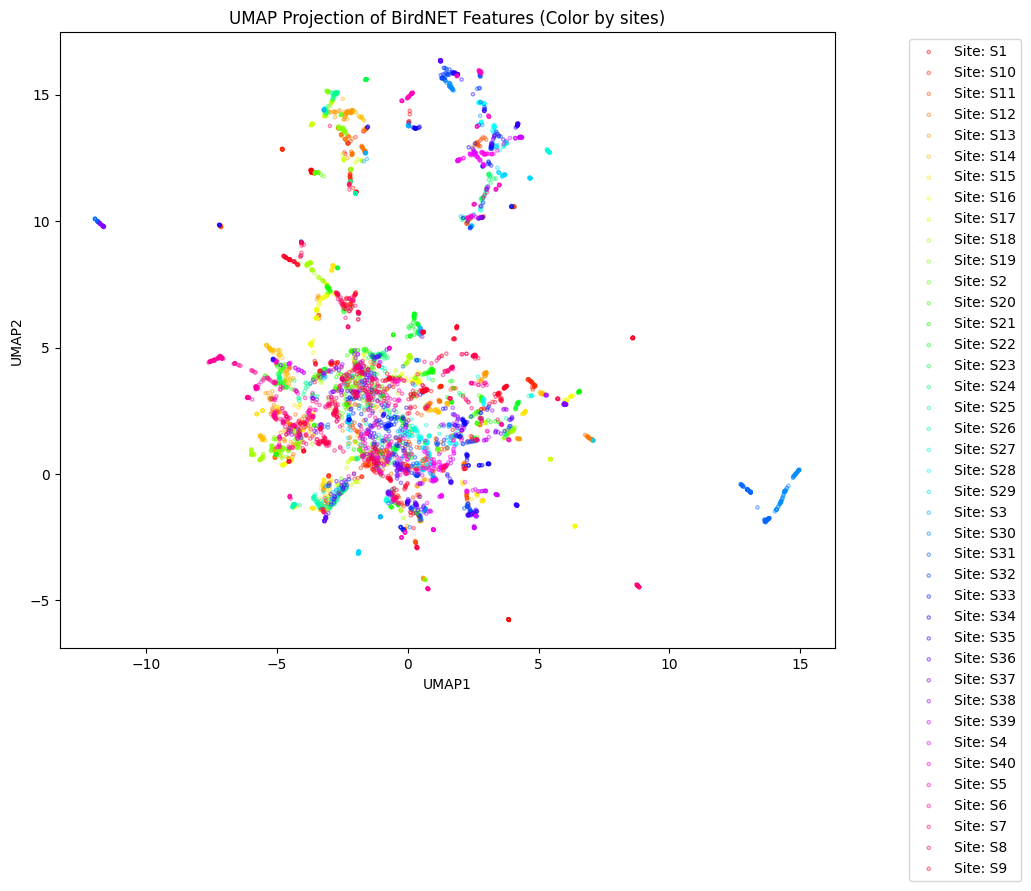

In [28]:
# Average Embeddings over 1 min Color by 40 sites
plt.figure(figsize=(10, 8))
for site_value_1, site_color_1 in site_color_mapping_aver_1.items():
    subset_1 = minute_averages[minute_averages['site'] == site_value_1]
    plt.scatter(subset_1['UMAP1'], subset_1['UMAP2'], edgecolor=site_color_1, facecolor='none', label=f'Site: {site_value_1}', alpha=0.5, s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of BirdNET Features (Color by sites)')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [29]:
color_mapping = {'00:00':'purple', '03:00':'brown', '05:45':'yellow', '08:00': 'red', '10:00': 'green', '15:00': 'blue', '18:00': 'orange', '21:00':'pink'}

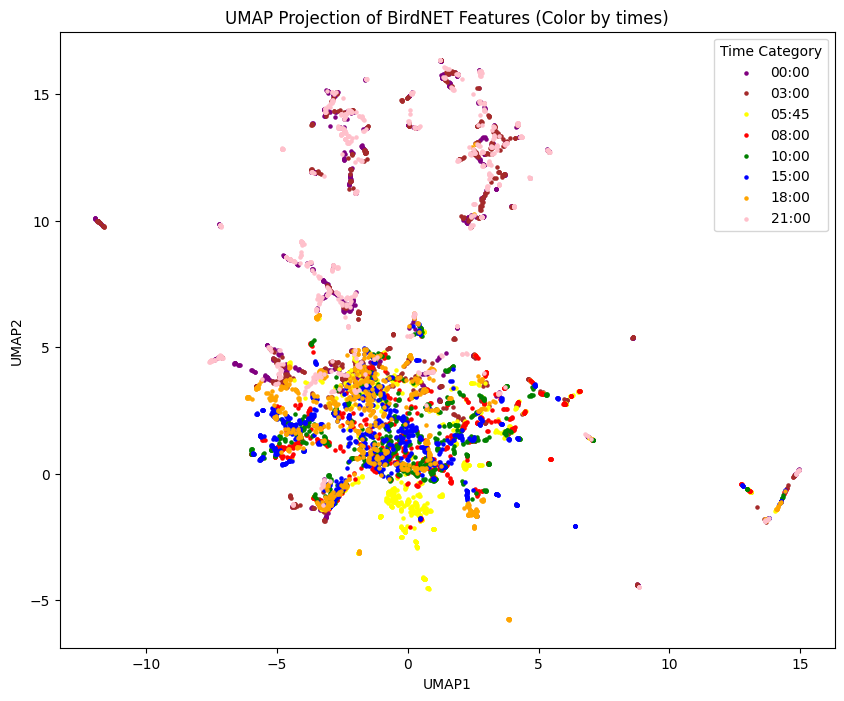

In [30]:
# Average Embeddings over 1 min Color by times
plt.figure(figsize=(10, 8))
for time_value_1, color_1 in color_mapping.items():
    subset_1 = minute_averages[minute_averages['time'] == time_value_1]
    plt.scatter(subset_1['UMAP1'], subset_1['UMAP2'], c=color_1, label=time_value_1, s=5)

plt.title('UMAP Projection of BirdNET Features (Color by times)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Time Category')
plt.show()

In [31]:
forest_cover_color_mapping = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}

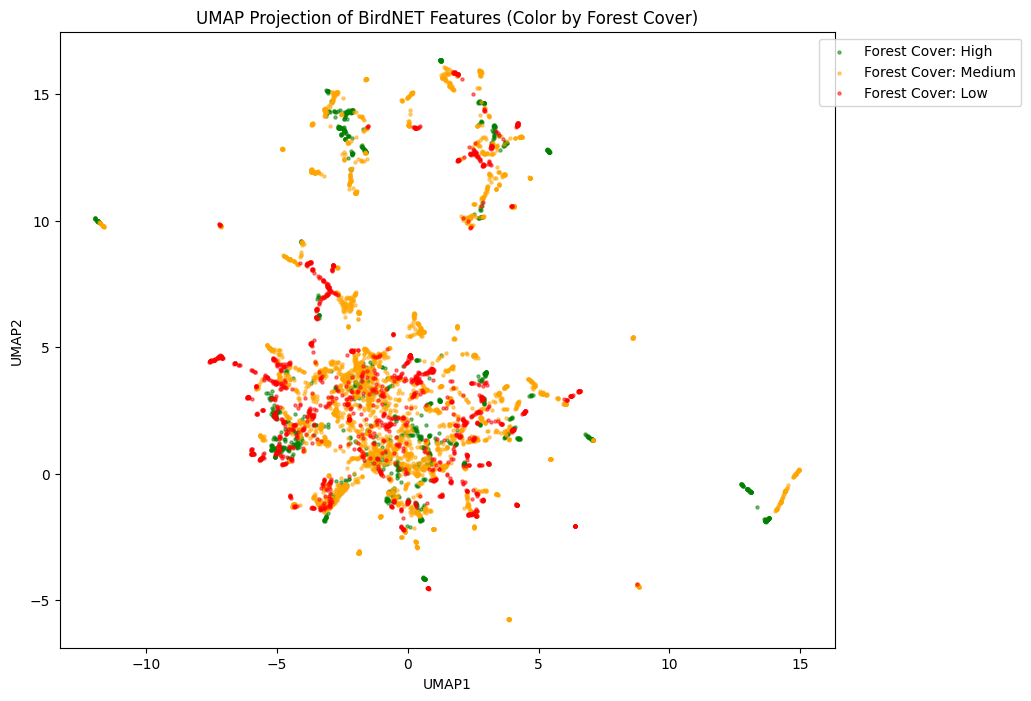

In [32]:
# Average embeddings over 1 min color by forest cover
plt.figure(figsize=(10, 8))
for cover_value, color in forest_cover_color_mapping.items():
    subset = minute_averages[minute_averages['Forest_Cover'] == cover_value]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=color, label=f'Forest Cover: {cover_value}', alpha=0.5, s=5)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of BirdNET Features (Color by Forest Cover)')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [33]:
alt_level_color_mapping = {'High': 'red', 'Medium': 'blue', 'Low': 'green'}

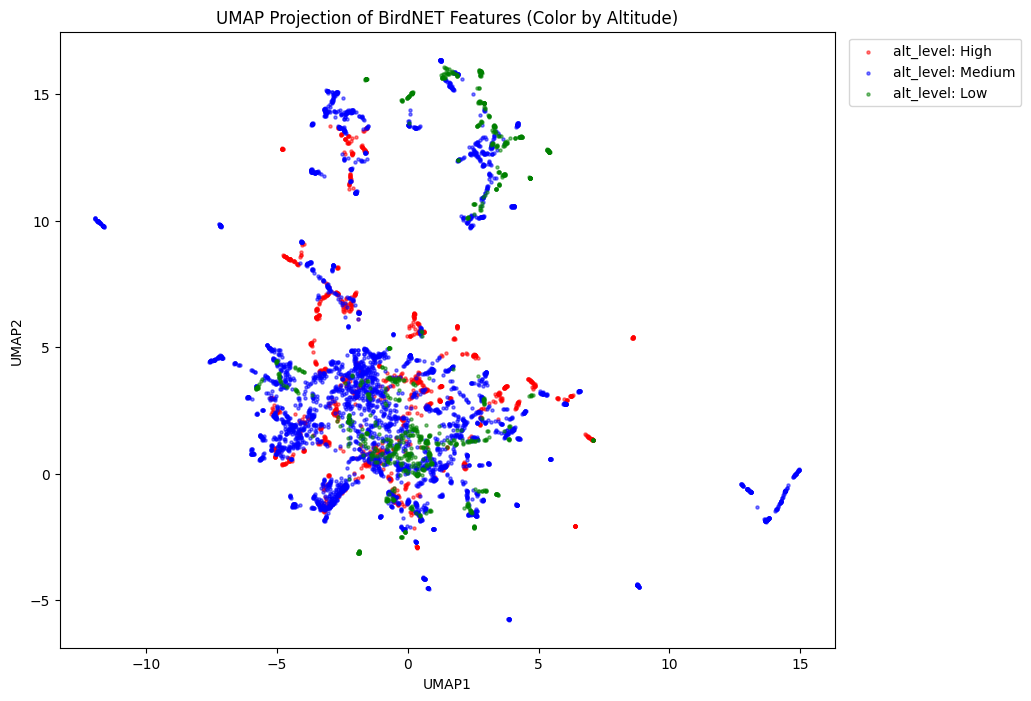

In [34]:
# Average embeddings over 1 min color by altitude level
plt.figure(figsize=(10, 8))
for alt_lvl_value, color in alt_level_color_mapping.items():
    subset = minute_averages[minute_averages['alt_level'] == alt_lvl_value]
    plt.scatter(subset['UMAP1'], subset['UMAP2'], c=color, label=f'alt_level: {alt_lvl_value}', alpha=0.5, s=5)

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP Projection of BirdNET Features (Color by Altitude)')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

In [35]:
def assign_day_night(row):
    if '08:00' <= row['time'] <= '18:00':
        return 'Day'
    else:
        return 'Night'

minute_averages['day_night'] = minute_averages.apply(assign_day_night, axis=1)


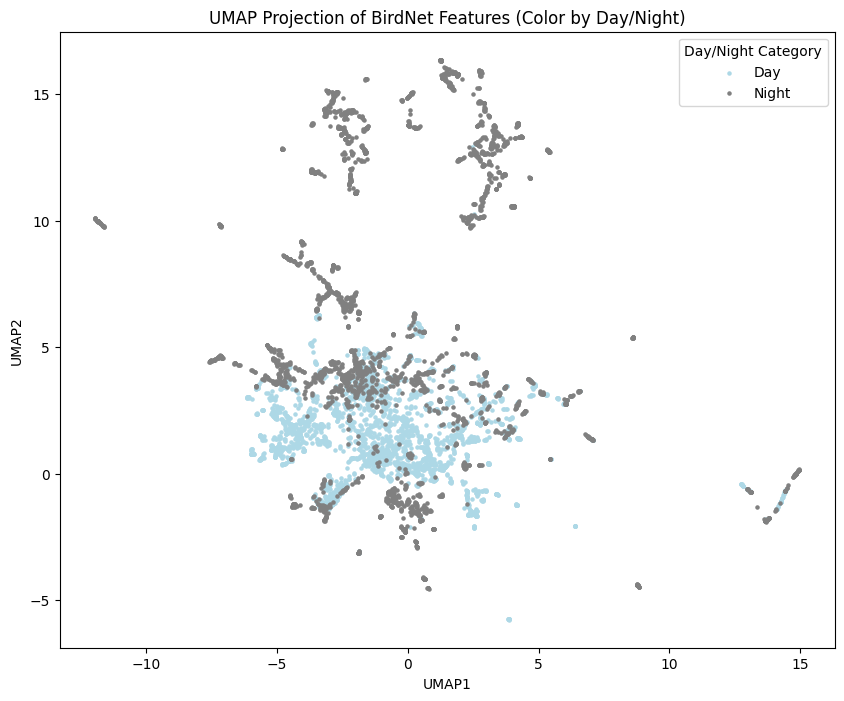

In [36]:
# Average Embeddings over 1 min Color by Day/Night
day_night_color_mapping = {'Day':'lightblue', 'Night': 'grey'}
plt.figure(figsize=(10, 8))
for day_night_value, color_3 in day_night_color_mapping.items():
    subset_3 = minute_averages[minute_averages['day_night'] == day_night_value]
    plt.scatter(subset_3['UMAP1'], subset_3['UMAP2'], c=color_3, label=day_night_value, s=5)

plt.title('UMAP Projection of BirdNet Features (Color by Day/Night)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Day/Night Category')
plt.show()

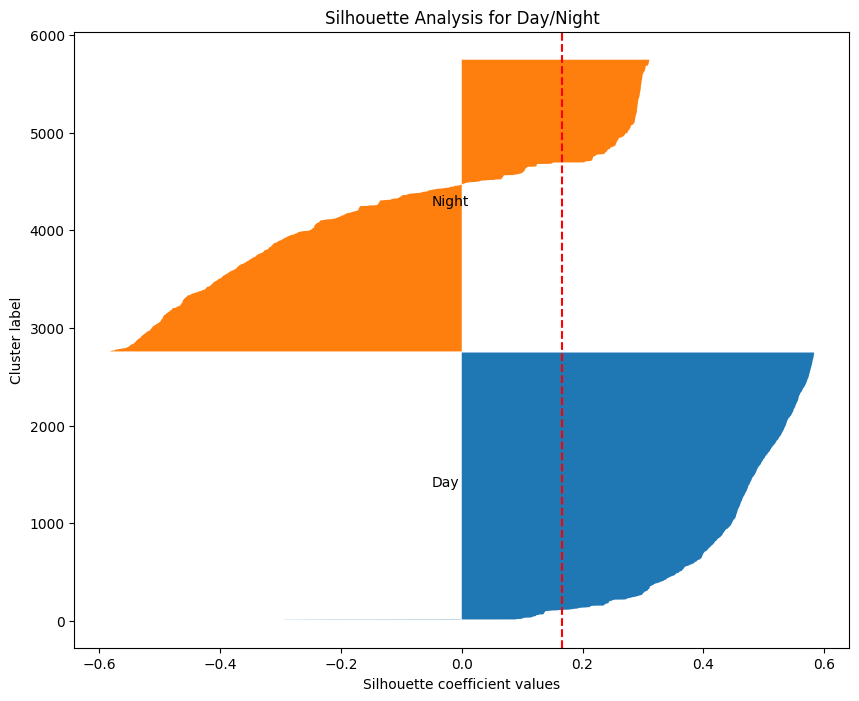

Silhouette Score for Day/Night: 0.16607557237148285


In [37]:
def silhouette_analysis(data, labels, title):
    silhouette_avg = silhouette_score(data, labels)
    sample_silhouette_values = silhouette_samples(data, labels)
    y_lower = 10

    plt.figure(figsize=(10, 8))
    for i in np.unique(labels):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.title(title)
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

    return silhouette_avg

silhouette_avg_day_night = silhouette_analysis(aver_2d_1, minute_averages['day_night'], 'Silhouette Analysis for Day/Night')
print(f'Silhouette Score for Day/Night: {silhouette_avg_day_night}')


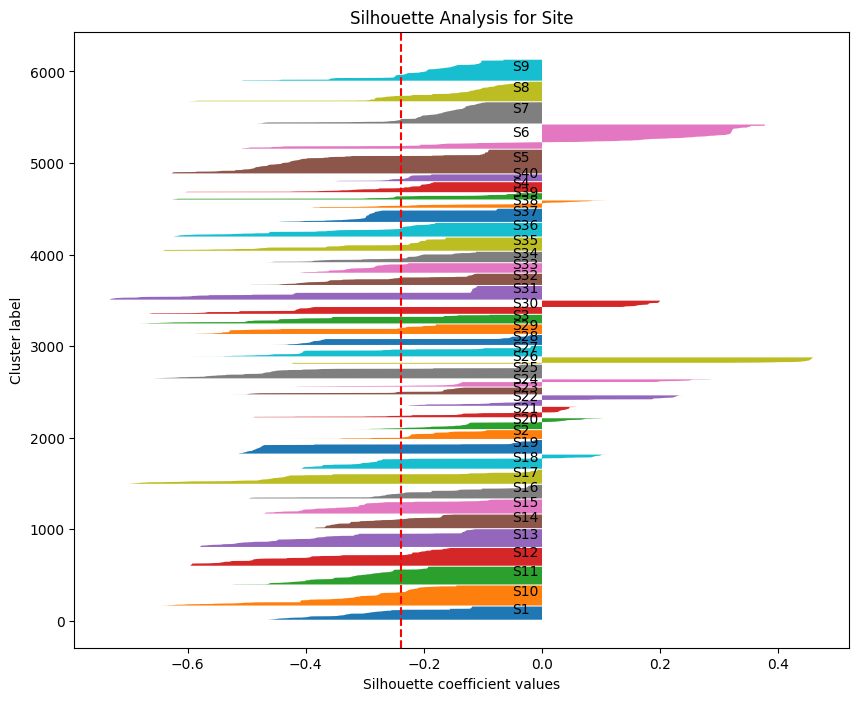

Silhouette Score for Site: -0.239299014210701


In [38]:
silhouette_avg_site = silhouette_analysis(aver_2d_1, minute_averages['site'], 'Silhouette Analysis for Site')
print(f'Silhouette Score for Site: {silhouette_avg_site}')

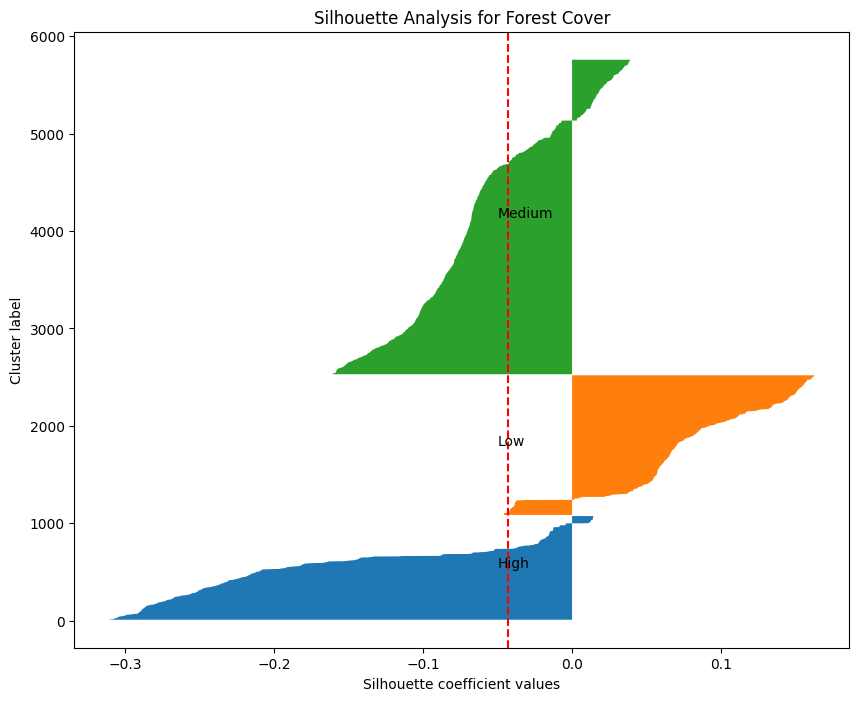

Silhouette Score for Forest Cover: -0.043158940970897675


In [39]:
silhouette_avg_forest_cover = silhouette_analysis(aver_2d_1, minute_averages['Forest_Cover'], 'Silhouette Analysis for Forest Cover')
print(f'Silhouette Score for Forest Cover: {silhouette_avg_forest_cover}')

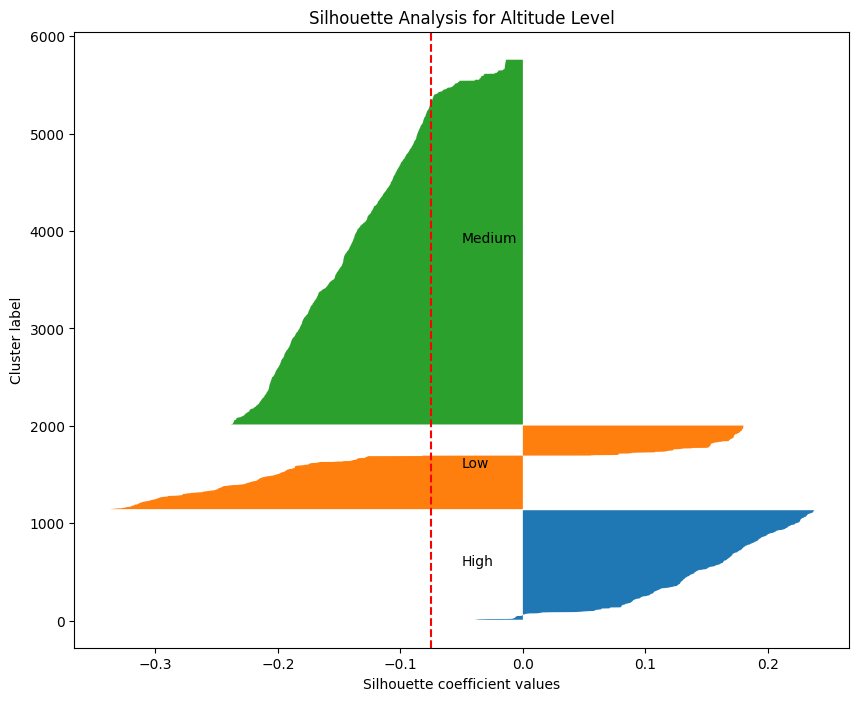

Silhouette Score for Altitude Level: -0.0748116746544838


In [40]:
silhouette_avg_alt_lvl = silhouette_analysis(aver_2d_1, minute_averages['alt_level'], 'Silhouette Analysis for Altitude Level')
print(f'Silhouette Score for Altitude Level: {silhouette_avg_alt_lvl}')

In [41]:
# Mixed Effect models analysis
mixed_effect_model_df = minute_averages.dropna(subset=['NDVI'])

In [42]:
mixed_effect_model_df

,1,2,3,4,5,6,7,8,9,10,...,Forest_Cover,alt,alt_level,PC1,PC2,PC3,PC4,UMAP1,UMAP2,day_night
0,0.737747,0.321804,0.199757,1.148175,0.617247,0.068538,0.164663,0.055251,0.115827,0.222751,...,Medium,966,Medium,-2.544192,-3.451008,-1.630348,-1.609007,3.858816,-5.763158,Day
1,0.744160,0.398255,0.285658,1.220065,0.601682,0.100306,0.221565,0.084049,0.098012,0.230972,...,Medium,966,Medium,-2.508890,-3.368652,-1.652775,-1.609419,3.859192,-5.763576,Day
2,0.743534,0.502413,0.236235,1.068902,0.321240,0.203735,0.291291,0.127624,0.022790,0.223548,...,Medium,966,Medium,-1.606292,-3.545845,-1.302532,-1.359263,3.842917,-5.743116,Day
3,0.737687,0.266936,0.217434,0.935921,0.423511,0.207963,0.083609,0.080737,0.112797,0.228495,...,Medium,966,Medium,-2.224425,-3.394017,-1.536243,-1.297245,3.856705,-5.759783,Day
4,0.698215,0.371960,0.216048,0.950592,0.604693,0.193568,0.096358,0.105427,0.097938,0.293194,...,Medium,966,Medium,-2.160440,-3.564458,-1.542103,-1.612592,3.869072,-5.777508,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,0.172305,0.201551,0.099482,0.655344,0.346617,0.045257,0.007022,0.329275,0.088447,0.730226,...,Medium,1471,High,-0.911386,-4.708406,-0.811609,-1.264652,0.215334,-2.138647,Night
5725,0.076707,0.192777,0.151829,0.706951,0.353370,0.070909,0.041273,0.188589,0.120235,0.522149,...,Medium,1471,High,-2.000002,-3.662748,-0.987495,-1.152131,0.116529,-1.528592,Night
5726,0.130333,0.177402,0.102814,0.640438,0.381724,0.173471,0.059907,0.271900,0.161195,0.488801,...,Medium,1471,High,-2.152045,-3.266132,-0.999653,-0.950986,0.087754,-1.505095,Night
5727,0.124633,0.281102,0.076158,0.417014,0.482330,0.079683,0.022426,0.291933,0.070392,0.786848,...,Medium,1471,High,-1.620292,-4.264374,-1.038010,-1.029228,0.115631,-1.638079,Night


In [43]:
mixed_effect_model_df = pd.merge(mixed_effect_model_df, AP_results, left_on='site', right_on='site', how='left')

In [44]:
mixed_effect_model_df.loc[:, 'log_NDVI'] = np.log(mixed_effect_model_df['NDVI'] + 1)

In [45]:
mixed_effect_model_df.loc[:, 'log_species_richness'] = np.log(mixed_effect_model_df['species_richness'] + 1)

In [46]:
mixed_effect_model_df.loc[:, 'log_alt'] = np.log(mixed_effect_model_df['alt'] + 1)

In [55]:
# mixed_effect_model_df = mixed_effect_model_df.drop(columns=['sqrt_PC1'])

Summary for PC1:
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   PC1        
No. Observations:    5254      Method:               REML       
No. Groups:          36        Scale:                7.8154     
Min. group size:     70        Log-Likelihood:       -12912.3126
Max. group size:     265       Converged:            Yes        
Mean group size:     145.9                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             25.035    8.160  3.068 0.002  9.042 41.028
C(day_night)[T.Night]  3.442    0.077 44.545 0.000  3.290  3.593
log_NDVI               0.658    3.051  0.216 0.829 -5.321  6.638
log_alt               -3.887    1.142 -3.403 0.001 -6.125 -1.648
Group Var              1.422    0.131                           

Intercept: 2.15410807

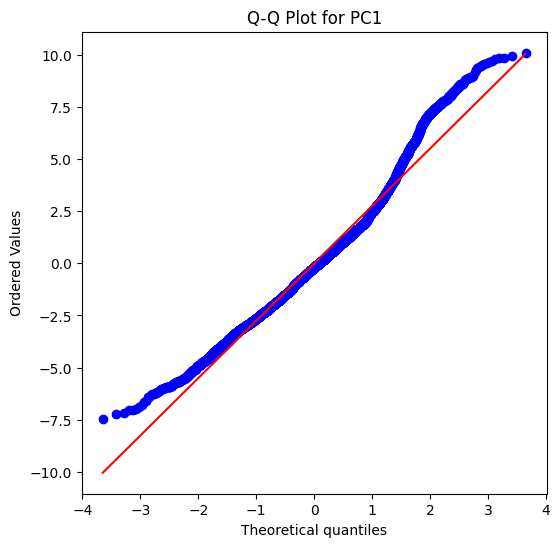

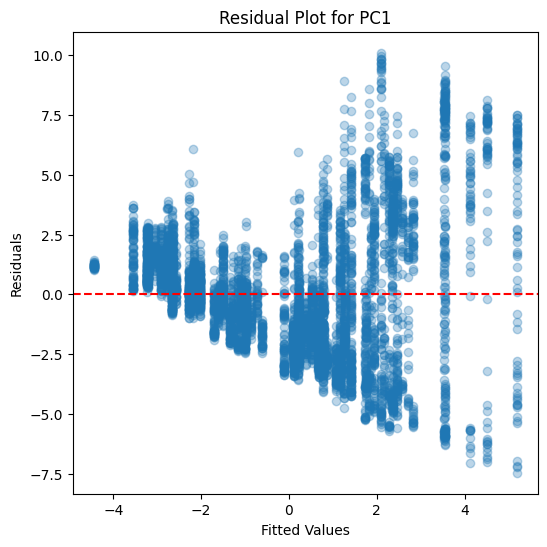

In [47]:
# Mixed Effect Models analysis, response variable [embeddings PCA] = NDVI + altitude + day/night as the predictor variables, and Site ID as the random effect.
# PCA1
formula_pc1 = f'PC1 ~ log_NDVI + log_alt + C(day_night)'
model_pc1 = MixedLM.from_formula(formula_pc1, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
result_pc1 = model_pc1.fit()
p_values_pc1 = result_pc1.pvalues
print(f'Summary for PC1:')
print(result_pc1.summary())
for param, p_val in p_values_pc1.items():
    print(f'{param}: {p_val:.20e}')

residuals_pc1 = result_pc1.resid
fitted_pc1 = result_pc1.fittedvalues

plt.figure(figsize=(6, 6))
stats.probplot(residuals_pc1, dist="norm", plot=plt)
plt.title(f'Q-Q Plot for PC1')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(fitted_pc1, residuals_pc1, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for PC1')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Summary for PC2:
              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   PC2        
No. Observations:     5254      Method:               REML       
No. Groups:           36        Scale:                5.5011     
Min. group size:      70        Log-Likelihood:       -11999.1404
Max. group size:      265       Converged:            Yes        
Mean group size:      145.9                                      
-----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
Intercept              2.075    8.886  0.234 0.815 -15.341 19.491
C(day_night)[T.Night]  0.517    0.065  7.980 0.000   0.390  0.644
log_NDVI               0.815    3.324  0.245 0.806  -5.700  7.330
log_alt               -0.358    1.244 -0.288 0.773  -2.796  2.079
Group Var              1.714    0.186                            

Interc

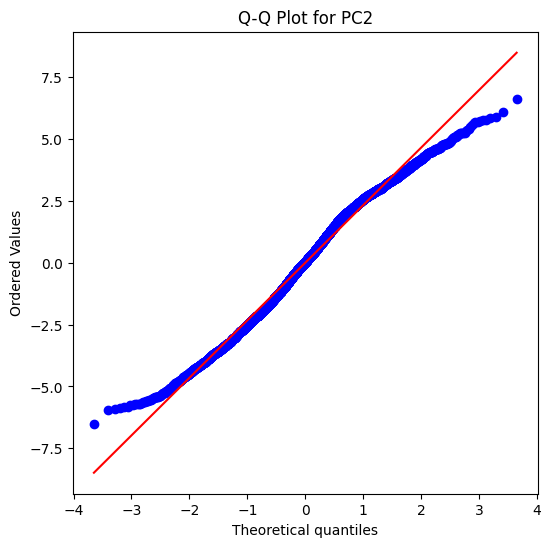

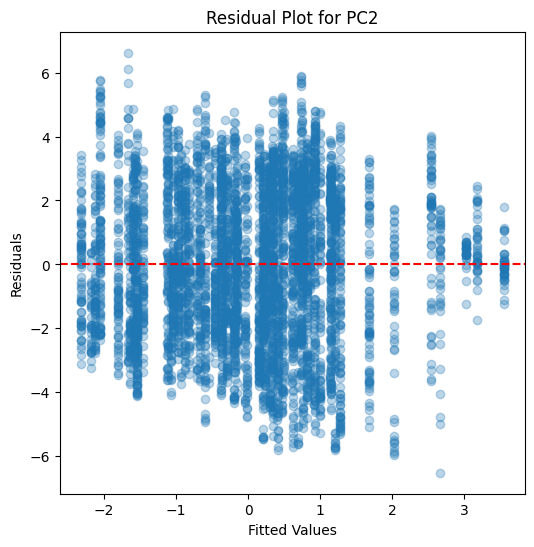

In [48]:
# PCA2
formula_pc2 = f'PC2 ~ log_NDVI + log_alt + C(day_night)'
model_pc2 = MixedLM.from_formula(formula_pc2, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
result_pc2 = model_pc2.fit()
p_values_pc2 = result_pc2.pvalues
print(f'Summary for PC2:')
print(result_pc2.summary())
for param, p_val in p_values_pc2.items():
    print(f'{param}: {p_val:.20e}')

residuals_pc2 = result_pc2.resid
fitted_pc2 = result_pc2.fittedvalues

plt.figure(figsize=(6, 6))
stats.probplot(residuals_pc2, dist="norm", plot=plt)
plt.title(f'Q-Q Plot for PC2')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(fitted_pc2, residuals_pc2, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for PC2')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Summary for PC3:
               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    PC3        
No. Observations:     5254       Method:                REML       
No. Groups:           36         Scale:                 3.3529     
Min. group size:      70         Log-Likelihood:        -10695.7534
Max. group size:      265        Converged:             Yes        
Mean group size:      145.9                                        
-------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept             -36.442    6.206 -5.872 0.000 -48.607 -24.278
C(day_night)[T.Night]   0.643    0.051 12.700 0.000   0.543   0.742
log_NDVI                4.492    2.321  1.935 0.053  -0.057   9.041
log_alt                 5.045    0.869  5.808 0.000   3.342   6.748
Group Var               0.831    0.116        

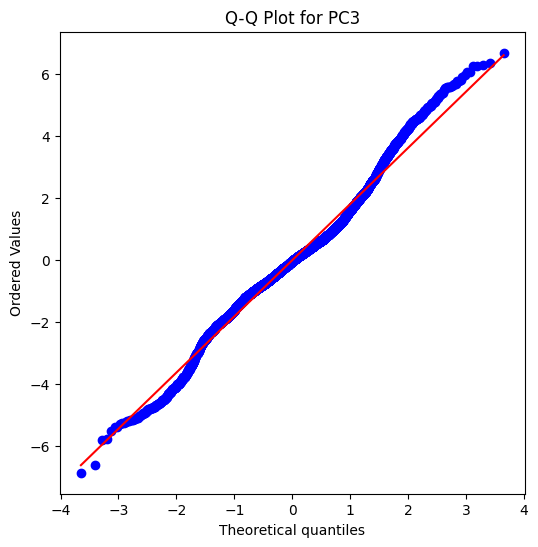

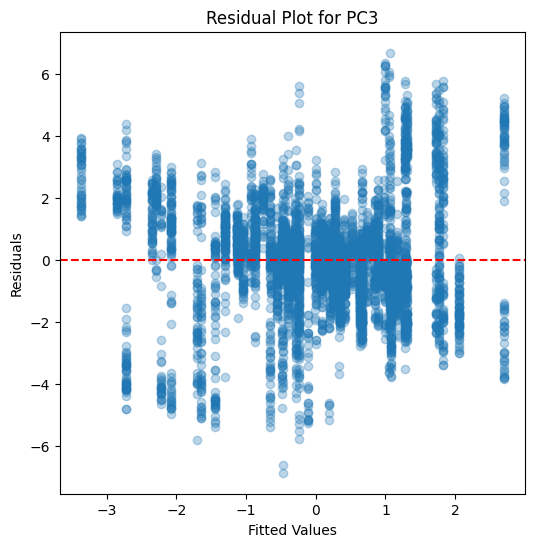

In [49]:
# PCA3
formula_pc3 = f'PC3 ~ log_NDVI + log_alt + C(day_night)'
model_pc3 = MixedLM.from_formula(formula_pc3, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
result_pc3 = model_pc3.fit()
p_values_pc3 = result_pc3.pvalues
print(f'Summary for PC3:')
print(result_pc3.summary())
for param, p_val in p_values_pc3.items():
    print(f'{param}: {p_val:.20e}')

residuals_pc3 = result_pc3.resid
fitted_pc3 = result_pc3.fittedvalues

plt.figure(figsize=(6, 6))
stats.probplot(residuals_pc3, dist="norm", plot=plt)
plt.title(f'Q-Q Plot for PC3')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(fitted_pc3, residuals_pc3, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for PC3')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Summary for PC4:
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    PC4       
No. Observations:    5254       Method:                REML      
No. Groups:          36         Scale:                 2.5250    
Min. group size:     70         Log-Likelihood:        -9957.6553
Max. group size:     265        Converged:             Yes       
Mean group size:     145.9                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
Intercept             -9.857    6.515 -1.513 0.130 -22.625  2.912
C(day_night)[T.Night]  0.300    0.044  6.836 0.000   0.214  0.386
log_NDVI               2.511    2.437  1.030 0.303  -2.266  7.289
log_alt                1.306    0.912  1.432 0.152  -0.482  3.093
Group Var              0.924    0.147                            

Interc

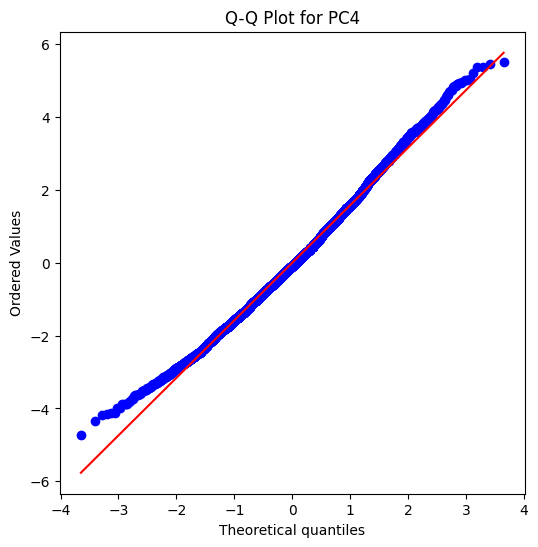

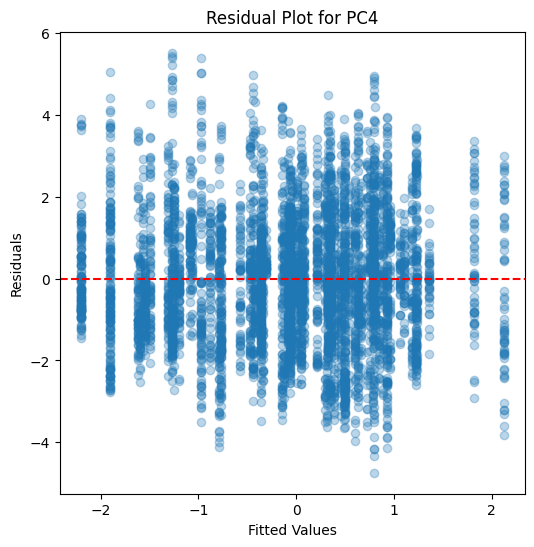

In [50]:
# PCA4
formula_pc4 = f'PC4 ~ log_NDVI + log_alt + C(day_night)'
model_pc4 = MixedLM.from_formula(formula_pc4, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
result_pc4 = model_pc4.fit()
p_values_pc4 = result_pc4.pvalues
print(f'Summary for PC4:')
print(result_pc4.summary())
for param, p_val in p_values_pc4.items():
    print(f'{param}: {p_val:.20e}')

residuals_pc4 = result_pc4.resid
fitted_pc4 = result_pc4.fittedvalues

plt.figure(figsize=(6, 6))
stats.probplot(residuals_pc4, dist="norm", plot=plt)
plt.title(f'Q-Q Plot for PC4')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(fitted_pc4, residuals_pc4, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for PC4')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

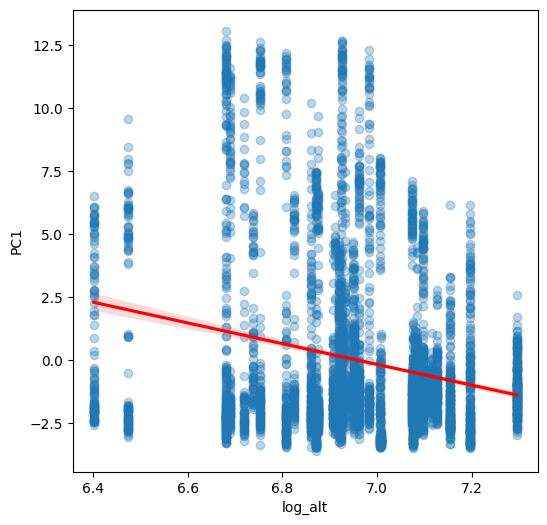

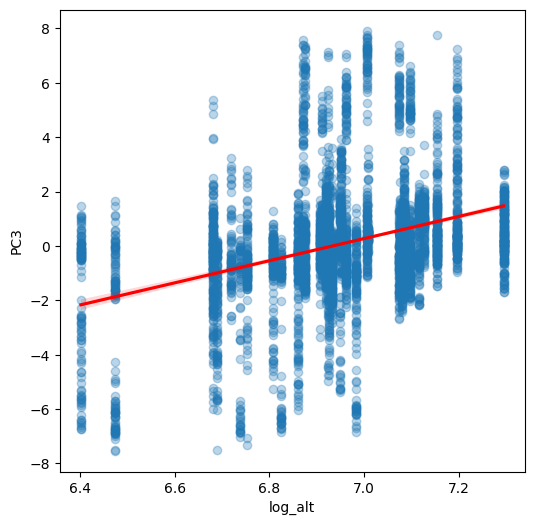

In [51]:
for i in [0, 2]:
    formula_plot = f'PC{i+1} ~ log_NDVI + log_alt + C(day_night)'
    model_plot = MixedLM.from_formula(formula_plot, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
    result_plot = model_plot.fit()

    data_plot = mixed_effect_model_df.copy()
    data_plot['fitted'] = result_plot.fittedvalues
    data_plot['residuals'] = result_plot.resid

    plt.figure(figsize=(6, 6))
    
    sns.regplot(x='log_alt', y=f'PC{i+1}', data=data_plot, 
                scatter_kws={'alpha':0.3}, 
                line_kws={'color':'red'},
                ci=95)
    
    plt.xlabel('log_alt')
    plt.ylabel(f'PC{i+1}')
    plt.show()

Summary for species richness:
              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_species_richness
No. Observations: 5254    Method:             REML                
No. Groups:       36      Scale:              0.0000              
Min. group size:  70      Log-Likelihood:     65333.0641          
Max. group size:  265     Converged:          Yes                 
Mean group size:  145.9                                           
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               10.937    0.703 15.547 0.000  9.558 12.315
C(day_night)[T.Night]   -0.000    0.000 -0.000 1.000 -0.000  0.000
NDVI                     0.357    0.219  1.635 0.102 -0.071  0.786
log_alt                 -0.758    0.099 -7.688 0.000 -0.951 -0.565
Group Var                0.011  250.441        

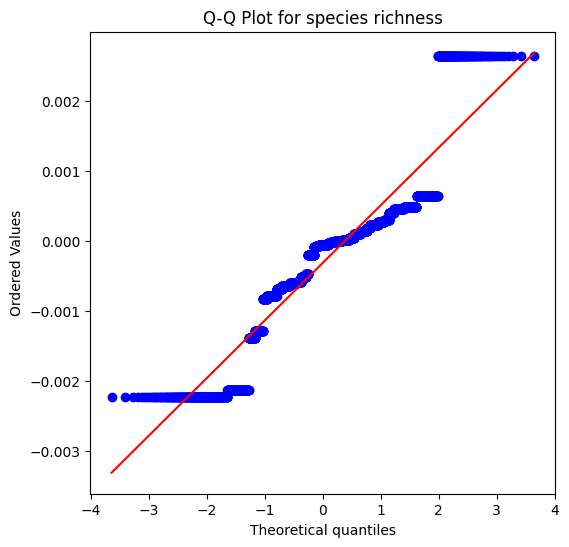

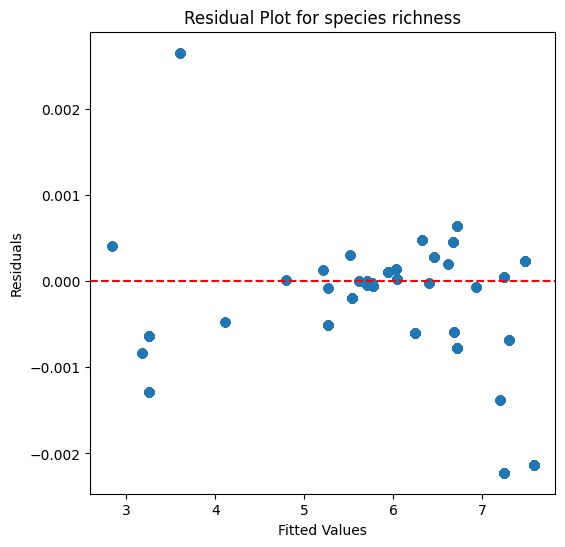

In [52]:
# Mixed Effect Models analysis, response variable [species richness per site] = NDVI + altitude + day/night as the predictor variables, and Site ID as the random intercept
formula_sr = f'log_species_richness ~ NDVI + log_alt + C(day_night)'
model_sr = MixedLM.from_formula(formula_sr, data=mixed_effect_model_df, groups=mixed_effect_model_df["site"])
result_sr = model_sr.fit()
p_values_sr = result_sr.pvalues
print(f'Summary for species richness:')
print(result_sr.summary())
for param, p_val in p_values_sr.items():
    print(f'{param}: {p_val:.20e}')

residuals_sr = result_sr.resid
fitted_sr = result_sr.fittedvalues

plt.figure(figsize=(6, 6))
stats.probplot(residuals_sr, dist="norm", plot=plt)
plt.title(f'Q-Q Plot for species richness')
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(fitted_sr, residuals_sr, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residual Plot for species richness')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()